In [43]:
# Get the data from the parquet file

from pyspark.sql import SparkSession
# memory issues .. see https://stackoverflow.com/questions/21138751/spark-java-lang-outofmemoryerror-java-heap-space
spark = SparkSession.builder.master("local[*]").appName("PropertyData").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) # Property used to format output tables better
spark
df = spark.read.parquet("/tmp/spark/tarrant-tx.parquet")

# Property used to format output tables better
# spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [47]:
# Multi-Linear Regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
from udfs import percent_diff_udf

# Define the feature columns
numerical_features = ['County', 'City', 'School', 'Total_Value']

# Drop rows containing missing values in the columns for features data,
cleaned_numeric_df = df.dropna(subset=numerical_features)
# and keep only those rows that are residential properties in a certain value range
cleaned_numeric_df = cleaned_numeric_df.where("(Total_Value between 100000 and 500000) and (RP = 'R')")

train_linear, test_linear = cleaned_numeric_df.randomSplit([0.5, 0.5])
model_linear = LinearRegression(featuresCol='features', labelCol='Appraised_Value_Int')
assembler = VectorAssembler(inputCols=numerical_features, outputCol='features')

# Train
train_linear = assembler.transform(train_linear)
test_linear = assembler.transform(test_linear)
linear_trained_model = model_linear.fit(train_linear)

# Evaluate
predictions = linear_trained_model.transform(test_linear)
evaluator = RegressionEvaluator(labelCol='Appraised_Value_Int', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)

# cast the predictions to integer and show the difference as integer and percentage
predictions = predictions.withColumn('prediction_int', predictions['prediction'].cast('int'))
predictions = predictions.drop('prediction')
predictions = predictions.withColumn('diff', col('Appraised_Value_Int') - col('prediction_int'))
predictions = predictions.withColumn('diff_percent', percent_diff_udf(col('prediction_int'), col('Appraised_Value_Int')))

# create the view with summary data
predictions.select('Account_Num', 'prediction_int', 'diff', 'diff_percent').createOrReplaceTempView("predictions")

print("Root Mean Squared Error (RMSE):", round(rmse, 2))

# update the view for SQL queries
df.createOrReplaceTempView("data")

23/06/20 17:27:53 WARN Instrumentation: [2408bb43] regParam is zero, which might cause numerical instability and overfitting.
23/06/20 17:27:54 WARN Instrumentation: [2408bb43] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Root Mean Squared Error (RMSE): 38544.96


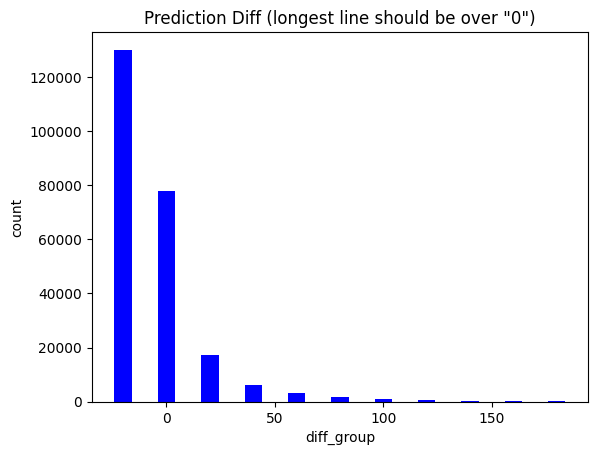

In [48]:
# let's take a look at some of the data
# we group the diff_percent values so there aren't too many records to graph
# also, here we are just looking at residential properties

query = """
with summary as (
  with src as (
    select FLOOR(CAST(diff_percent as INT) / 20) * 20 AS diff_group
    from predictions
    join data on data.Account_Num = predictions.Account_Num
    where data.RP = 'R'
      and Appraised_Value_Int > 20000
  )
  select count(diff_group) as count, diff_group from src group by 2 order by 2 desc
)
select count, diff_group from summary where count > 100
"""
res = spark.sql(query)
# res.show()

# graph it show how the predictions differ from the current appraisal values
import matplotlib.pyplot as plt
pandas_df = res.toPandas()
plt.bar(pandas_df['diff_group'], pandas_df['count'], color='blue', width=8)
plt.xlabel('diff_group')
plt.ylabel('count')
plt.title('Prediction Diff (longest line should be over "0")') # .. which would indicate more accurate prediction
plt.show()